# 데이터 불러오기

In [ ]:
# https://understat.com/
# Understats 사이트의 비공식 API wrapper 설치
# 상업적 사용 제외 가능
!pip install understat aiohttp 

참고 사이트: https://github.com/amosbastian/understat

In [1]:
import asyncio, aiohttp, pandas as pd
from understat import Understat

LEAGUE = "epl"
SEASON = 2024   # 2024/25 시즌

async def fetch_match_ids(league, season):
    async with aiohttp.ClientSession() as sess:
        us = Understat(sess)
        results = await us.get_league_results(league, season) # 리그, 시즌에 해당하는 모든 JSON을 가져옴
        match_ids = [int(r["id"]) for r in results] # 경기 ID 별로 정리
        return results, match_ids

results, match_ids = await fetch_match_ids(LEAGUE, SEASON)
print(len(match_ids))      # 경기 수(20팀이 Home/Away로 각 팀과 두번씩 경기를 진행)
pd.DataFrame(results).head()

380


,id,isResult,h,a,goals,xG,datetime,forecast
0,26602,True,"{'id': '89', 'title': 'Manchester United', 'sh...","{'id': '228', 'title': 'Fulham', 'short_title'...","{'h': '1', 'a': '0'}","{'h': '2.04268', 'a': '0.418711'}",2024-08-16 19:00:00,"{'w': '0.8069', 'd': '0.1489', 'l': '0.0442'}"
1,26603,True,"{'id': '285', 'title': 'Ipswich', 'short_title...","{'id': '87', 'title': 'Liverpool', 'short_titl...","{'h': '0', 'a': '2'}","{'h': '0.342601', 'a': '3.92906'}",2024-08-17 11:30:00,"{'w': '0.0026', 'd': '0.018', 'l': '0.9794'}"
2,26604,True,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '229', 'title': 'Wolverhampton Wanderer...","{'h': '2', 'a': '0'}","{'h': '1.6283', 'a': '0.575835'}",2024-08-17 14:00:00,"{'w': '0.6528', 'd': '0.231', 'l': '0.1162'}"
3,26605,True,"{'id': '72', 'title': 'Everton', 'short_title'...","{'id': '220', 'title': 'Brighton', 'short_titl...","{'h': '0', 'a': '3'}","{'h': '0.405325', 'a': '1.79083'}",2024-08-17 14:00:00,"{'w': '0.0481', 'd': '0.1635', 'l': '0.7884'}"
4,26606,True,"{'id': '86', 'title': 'Newcastle United', 'sho...","{'id': '74', 'title': 'Southampton', 'short_ti...","{'h': '1', 'a': '0'}","{'h': '0.433489', 'a': '1.95483'}",2024-08-17 14:00:00,"{'w': '0.0378', 'd': '0.164', 'l': '0.7982'}"


In [2]:
async def fetch_shots_for_matches(match_ids, concurrency=8): # 동시에 최대 8개의 요청만 보내도록 제한(과부화 방지)
    sem = asyncio.Semaphore(concurrency)
    shots_all = []
    async with aiohttp.ClientSession() as sess:
        us = Understat(sess)

        async def fetch_one(mid):
            async with sem:
                d = await us.get_match_shots(mid)
                for side in ("h","a"): # Home/Away로 구분
                    for s in d.get(side, []):
                        s["side"] = side
                        s["match_id"] = mid
                        shots_all.append(s)

        await asyncio.gather(*(fetch_one(m) for m in match_ids))
    return shots_all

shots = await fetch_shots_for_matches(match_ids, concurrency=8)
shots_df = pd.DataFrame(shots)
shots_df.to_csv("epl2024_shots.csv", index=False)
shots_df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
0,584686,1,BlockedShot,0.8569999694824219,0.3270000076293945,0.04620541259646416,Omari Hutchinson,h,10348,OpenPlay,...,RightFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None,h
1,584688,19,SavedShot,0.9130000305175782,0.5070000076293946,0.05428255349397659,Jacob Greaves,h,12745,SetPiece,...,Head,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Sam Morsy,Aerial,h
2,584690,31,SavedShot,0.7880000305175782,0.45,0.08377160131931305,Omari Hutchinson,h,10348,OpenPlay,...,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Liam Delap,TakeOn,h
3,584691,40,MissedShots,0.91,0.534000015258789,0.048458486795425415,Axel Tuanzebe,h,934,SetPiece,...,Head,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,Aerial,h
4,584701,67,MissedShots,0.8540000152587891,0.4909999847412109,0.04051180183887482,Omari Hutchinson,h,10348,OpenPlay,...,RightFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Liam Delap,Aerial,h


In [3]:
shots_df.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
9873,636431,53,MissedShots,0.9630000305175781,0.46799999237060547,0.13503046333789825,Manuel Akanji,a,6490,FromCorner,...,Head,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,Bernardo Silva,Cross,a
9874,636432,54,BlockedShot,0.785,0.6320000076293946,0.0354330837726593,Erling Haaland,a,8260,OpenPlay,...,LeftFoot,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,Bernardo Silva,Pass,a
9875,636433,59,MissedShots,0.9580000305175781,0.5740000152587891,0.06427739560604095,Erling Haaland,a,8260,SetPiece,...,Head,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,None,Aerial,a
9876,636435,71,Goal,0.885,0.5,0.7611688375473022,Erling Haaland,a,8260,Penalty,...,LeftFoot,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,None,Standard,a
9877,636436,75,MissedShots,0.8980000305175782,0.29700000762939455,0.060841310769319534,Erling Haaland,a,8260,OpenPlay,...,LeftFoot,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,Matheus Nunes,Pass,a


# 데이터 확인

In [4]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               9878 non-null   object
 1   minute           9878 non-null   object
 2   result           9878 non-null   object
 3   X                9878 non-null   object
 4   Y                9878 non-null   object
 5   xG               9878 non-null   object
 6   player           9878 non-null   object
 7   h_a              9878 non-null   object
 8   player_id        9878 non-null   object
 9   situation        9878 non-null   object
 10  season           9878 non-null   object
 11  shotType         9878 non-null   object
 12  match_id         9878 non-null   int64 
 13  h_team           9878 non-null   object
 14  a_team           9878 non-null   object
 15  h_goals          9878 non-null   object
 16  a_goals          9878 non-null   object
 17  date             9878 non-null   

In [5]:
# player_assisted의 결측값은 어시스트한 선수가 없을 때 Null값을 가짐
# minute, X, Y, xG, h_goals, a_goals 등은 수치형 데이터이지만 object로 나와있는 것을 확인할 수 있음

In [6]:
shots_df.nunique()

id                 9878
minute              104
result                6
X                   380
Y                   584
xG                 9761
player              458
h_a                   2
player_id           458
situation             5
season                1
shotType              4
match_id            380
h_team               20
a_team               20
h_goals               7
a_goals               7
date                216
player_assisted     460
lastAction           31
side                  2
dtype: int64

In [7]:
shots_df['result'].unique()

array(['BlockedShot', 'SavedShot', 'MissedShots', 'Goal', 'ShotOnPost',
       'OwnGoal'], dtype=object)

In [8]:
shots_df['situation'].unique()

array(['OpenPlay', 'SetPiece', 'FromCorner', 'DirectFreekick', 'Penalty'],
      dtype=object)

In [9]:
shots_df['shotType'].unique()

array(['RightFoot', 'Head', 'LeftFoot', 'OtherBodyPart'], dtype=object)

In [10]:
shots_df['lastAction'].unique()

array(['None', 'Aerial', 'TakeOn', 'Pass', 'BallTouch', 'Cross',
       'Throughball', 'Rebound', 'Chipped', 'BallRecovery', 'Standard',
       'Tackle', 'Dispossessed', 'HeadPass', 'LayOff', 'Foul',
       'CornerAwarded', 'Goal', 'Save', 'Card', 'Interception',
       'Challenge', 'OffsidePass', 'BlockedPass', 'OffsideProvoked',
       'End', 'Clearance', 'ShieldBallOpp', 'ChanceMissed',
       'FormationChange', 'KeeperPickup'], dtype=object)

In [11]:
# id: 슛 이벤트 고유 id
# minute: 슛이 발생한 시간
# result: 슛 결과
# X,Y: 슛이 발생한 경기장 내의 좌표
# xG: 기대 득점
# player: 선수명
# h_a: Home/away
# player_id: 선수 고유 ID
# situation: 슛상황(OpenPlay/ Penalty, FromCorner, SetPiece, DirectFreekick)
# season: 시즌 연도
# shotType: 슛 종류(RightFoot/ LeftFoot/ Head/ OtherBodyPart)
# match_id: 경기 고유 ID
# h_team: 홈 팀명
# a_team: 어웨이 팀명
# h_goals: 홈 팀 최종 득점 수
# a_goals: 어웨이 팀 최종 득점 수
# date: 날짜(년-월-일 시-분-초)
# player_assisted : 어시스트한 선수(없으면 결측)
# lastAction: 슛 직전 일어난 액션
# side: 홈/원정 여부 (h_a랑 중복)

In [12]:
shots_df.describe()

,match_id
count,9878.000000
mean,26788.936931
std,109.720566
min,26602.000000
25%,26693.000000
50%,26787.000000
75%,26884.000000
max,26981.000000


In [13]:
shots_df.describe(include='all')

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
count,9878,9878,9878,9878,9878,9878,9878,9878,9878,9878,...,9878,9878.000000,9878,9878,9878,9878,9878,7377,9878,9878
unique,9878,104,6,380,584,9761,458,2,458,5,...,4,NaN,20,20,7,7,216,460,31,2
top,584686,46,MissedShots,0.885,0.5,0.7611688375473022,Mohamed Salah,h,1250,OpenPlay,...,RightFoot,NaN,Brentford,West Ham,1,1,2025-05-25 15:00:00,Bruno Fernandes,Pass,h
freq,1,179,3346,121,118,83,130,5230,130,7318,...,4819,NaN,551,566,3068,3479,268,92,3764,5230
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26788.936931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,109.720566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26602.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26693.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26787.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26884.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# object형태로 표시된 수치형 데이터를 변환 후 다시 확인

# 변환할 컬럼 목록
int_cols = ["minute", "h_goals", "a_goals"]
float_cols = ["X", "Y", "xG"]

shots_df[int_cols] = shots_df[int_cols].apply(pd.to_numeric, errors="coerce").astype("Int64")
shots_df[float_cols] = shots_df[float_cols].apply(pd.to_numeric, errors="coerce").astype(float)

shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9878 non-null   object 
 1   minute           9878 non-null   Int64  
 2   result           9878 non-null   object 
 3   X                9878 non-null   float64
 4   Y                9878 non-null   float64
 5   xG               9878 non-null   float64
 6   player           9878 non-null   object 
 7   h_a              9878 non-null   object 
 8   player_id        9878 non-null   object 
 9   situation        9878 non-null   object 
 10  season           9878 non-null   object 
 11  shotType         9878 non-null   object 
 12  match_id         9878 non-null   int64  
 13  h_team           9878 non-null   object 
 14  a_team           9878 non-null   object 
 15  h_goals          9878 non-null   Int64  
 16  a_goals          9878 non-null   Int64  
 17  date          

In [15]:
shots_df.describe()

,minute,X,Y,xG,match_id,h_goals,a_goals
count,9878.0,9878.000000,9878.000000,9878.000000,9878.000000,9878.0,9878.0
mean,49.010427,0.858118,0.502775,0.125181,26788.936931,1.554667,1.464466
std,26.965631,0.086710,0.120866,0.167522,109.720566,1.283929,1.19417
min,0.0,0.006000,0.056000,0.000000,26602.000000,0.0,0.0
25%,26.0,0.808000,0.415000,0.031771,26693.000000,1.0,1.0
50%,49.0,0.872000,0.503000,0.059666,26787.000000,1.0,1.0
75%,71.0,0.915000,0.588000,0.110777,26884.000000,2.0,2.0
max,103.0,0.994000,0.995000,0.979322,26981.000000,7.0,6.0


In [16]:
shots_df.describe(include='all')

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
count,9878,9878.0,9878,9878.000000,9878.000000,9878.000000,9878,9878,9878,9878,...,9878,9878.000000,9878,9878,9878.0,9878.0,9878,7377,9878,9878
unique,9878,<NA>,6,NaN,NaN,NaN,458,2,458,5,...,4,NaN,20,20,<NA>,<NA>,216,460,31,2
top,584686,<NA>,MissedShots,NaN,NaN,NaN,Mohamed Salah,h,1250,OpenPlay,...,RightFoot,NaN,Brentford,West Ham,<NA>,<NA>,2025-05-25 15:00:00,Bruno Fernandes,Pass,h
freq,1,<NA>,3346,NaN,NaN,NaN,130,5230,130,7318,...,4819,NaN,551,566,<NA>,<NA>,268,92,3764,5230
mean,NaN,49.010427,NaN,0.858118,0.502775,0.125181,NaN,NaN,NaN,NaN,...,NaN,26788.936931,NaN,NaN,1.554667,1.464466,NaN,NaN,NaN,NaN
std,NaN,26.965631,NaN,0.086710,0.120866,0.167522,NaN,NaN,NaN,NaN,...,NaN,109.720566,NaN,NaN,1.283929,1.19417,NaN,NaN,NaN,NaN
min,NaN,0.0,NaN,0.006000,0.056000,0.000000,NaN,NaN,NaN,NaN,...,NaN,26602.000000,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
25%,NaN,26.0,NaN,0.808000,0.415000,0.031771,NaN,NaN,NaN,NaN,...,NaN,26693.000000,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
50%,NaN,49.0,NaN,0.872000,0.503000,0.059666,NaN,NaN,NaN,NaN,...,NaN,26787.000000,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
75%,NaN,71.0,NaN,0.915000,0.588000,0.110777,NaN,NaN,NaN,NaN,...,NaN,26884.000000,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN


# 분석 목적/ 인사이트

## 분석 목적

- 슛 이벤트 데이터를 활용해“슛이 골로 이어질 확률(xG)”을 직접 예측하는 모델을 구축
- Target: result → is_goal (0/1)
- Understat에서 제공하는 xG와 직접 만든 xG를 비교,평가
    - Understat의 xG값을 정답값으로 사용 예정
- 제공되는 xG값이 있는데 다시 예측하는 이유
    - 실제 산업에서 쓰이는 모델 재현
    - 변수 영향력 확인

## 기대 인사이트

###  모델링 성능 비교
- 모델이 Understat xG와 얼마나 유사하게 작동하는가?
- 특정 상황(예: 페널티킥, 장거리슛)에서 Understat의 차이가 두드러지는가?

### 선수 단위 분석
- 선수별 실제 득점 vs 내 xG vs Understat xG
- 골 결정력이 좋은 선수(실제 득점 > xG) vs 마무리가 부족한 선수(실제 득점 < xG) 확인

### 팀 단위 분석
- 경기별/시즌별 실제 득점 vs 예측 xG 비교
- Over-performing 팀(득점 > xG) vs Under-performing 팀(득점 < xG) 도출
- 전술적 효율성 분석

### 모델 해석력
- 어떤 변수가 골 확률에 가장 크게 영향을 미치는지 확인 (예: 슛 거리, 각도, 슛 타입, 상황)

# EDA

In [17]:
shots_df['is_goal']=(shots_df['result'] == "Goal").astype(int)
shots_df['is_goal'].value_counts(normalize=True)

0    0.890565
1    0.109435
Name: is_goal, dtype: float64

전체 슈팅 중 노골이 약 89%

In [18]:
print(shots_df['situation'].value_counts())

OpenPlay          7318
FromCorner        1619
SetPiece           589
DirectFreekick     269
Penalty             83
Name: situation, dtype: int64


In [19]:
print(shots_df['shotType'].value_counts())

RightFoot        4819
LeftFoot         3288
Head             1729
OtherBodyPart      42
Name: shotType, dtype: int64


In [20]:
print(shots_df['lastAction'].value_counts())

Pass               3764
Cross              1310
None               1134
Aerial              807
Rebound             501
TakeOn              456
Chipped             417
Standard            352
BallRecovery        261
Throughball         231
BallTouch           228
HeadPass            187
Dispossessed         53
LayOff               45
Foul                 27
Tackle               24
CornerAwarded        18
BlockedPass          15
Interception          7
End                   7
Goal                  6
Save                  5
Clearance             5
Challenge             4
OffsidePass           4
Card                  3
OffsideProvoked       2
FormationChange       2
ShieldBallOpp         1
ChanceMissed          1
KeeperPickup          1
Name: lastAction, dtype: int64


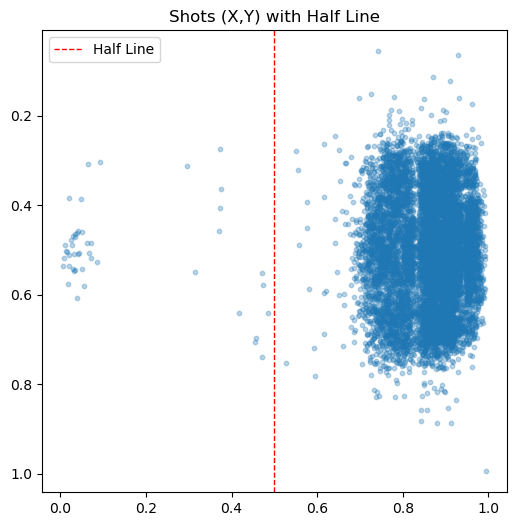

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(shots_df['X'].astype(float), shots_df['Y'].astype(float), alpha=0.3, s=10)

# 하프라인 (X=0.5)
plt.axvline(0.5, color='red', linestyle='--', linewidth=1, label='Half Line')

# 좌표계 뒤집기 (Understat Y축 방향 맞춤)
plt.gca().invert_yaxis()

plt.title("Shots (X,Y) with Half Line")
plt.legend()
plt.show()

X=0 -> 자기 진영,  X=1 -> 상대진영

Y=0 -> 왼쪽, Y=1 -> 오른쪽

(0.5,0.5) -> 센터 스팟

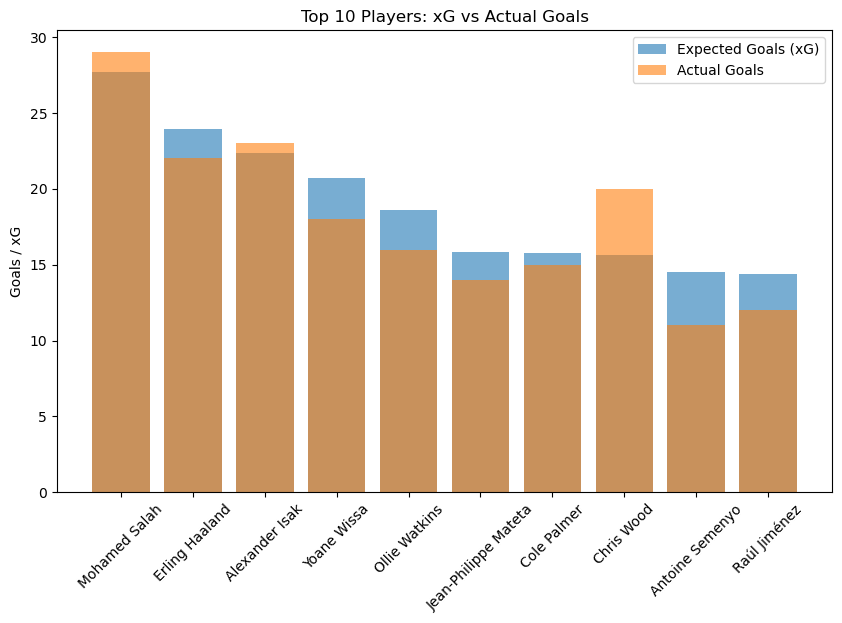

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

player_stats = shots_df.groupby('player').agg(
    total_xG=('xG', 'sum'),
    goals=('result', lambda x: (x == 'Goal').sum()),
    shots=('xG', 'count')
).reset_index()

# xG vs Goals barplot
top_players = player_stats.sort_values('total_xG', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_players['player'], top_players['total_xG'], label='Expected Goals (xG)', alpha=0.6)
plt.bar(top_players['player'], top_players['goals'], label='Actual Goals', alpha=0.6)
plt.xticks(rotation=45)
plt.ylabel("Goals / xG")
plt.title("Top 10 Players: xG vs Actual Goals")
plt.legend()
plt.show()

득점 상위 10명의 선수 중 xG값보다 실제 골이 많은 선수는 살라, 이삭, 우드 선수

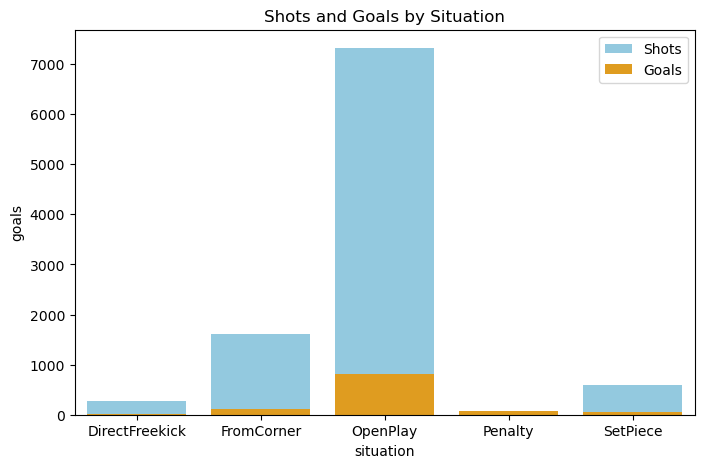

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# situation 별 슛 수와 골 수
situation_stats = shots_df.groupby('situation').agg(
    shots=('id','count'),
    goals=('result', lambda x: (x == 'Goal').sum())
).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=situation_stats, x='situation', y='shots', color='skyblue', label='Shots')
sns.barplot(data=situation_stats, x='situation', y='goals', color='orange', label='Goals')
plt.title("Shots and Goals by Situation")
plt.legend()
plt.show()

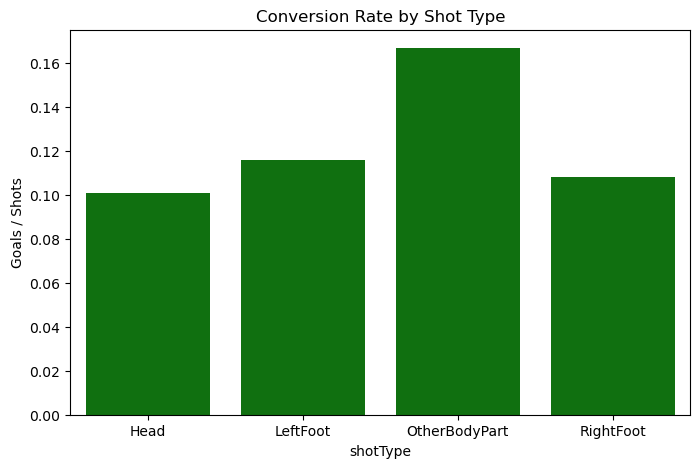

In [24]:
# shotType 별 성공률
shottype_stats = shots_df.groupby('shotType').agg(
    shots=('id','count'),
    goals=('result', lambda x: (x == 'Goal').sum())
).reset_index()
shottype_stats['conversion_rate'] = shottype_stats['goals'] / shottype_stats['shots']

plt.figure(figsize=(8,5))
sns.barplot(data=shottype_stats, x='shotType', y='conversion_rate', color='green')
plt.title("Conversion Rate by Shot Type")
plt.ylabel("Goals / Shots")
plt.show()

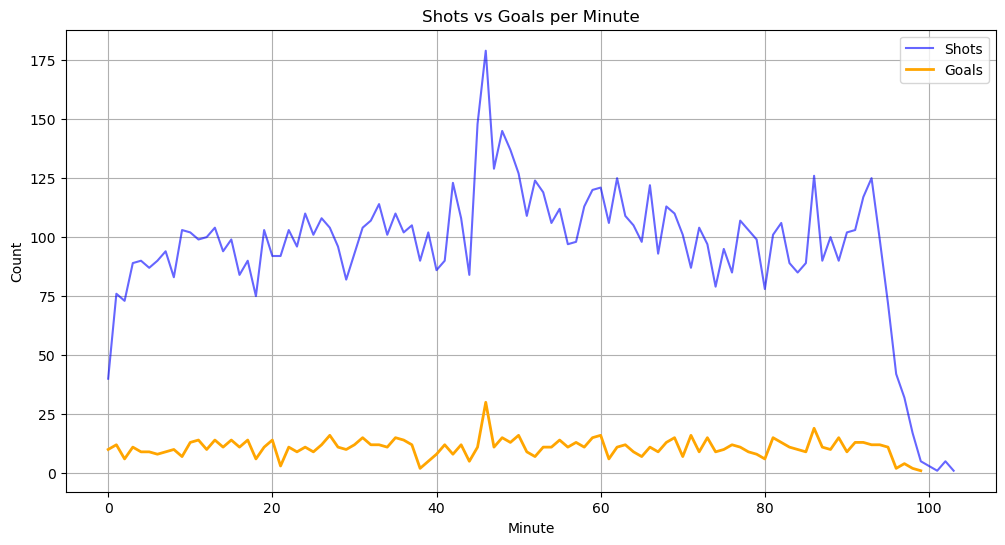

In [25]:
# 슛
minute_counts = shots_df.groupby('minute').size()
# 골
goals_df = shots_df[shots_df['result'] == 'Goal']
goal_counts = goals_df.groupby('minute').size()

plt.figure(figsize=(12,6))
plt.plot(minute_counts.index, minute_counts.values, label='Shots', color='blue', alpha=0.6)
plt.plot(goal_counts.index, goal_counts.values, label='Goals', color='orange', linewidth=2)
plt.title("Shots vs Goals per Minute")
plt.xlabel("Minute")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


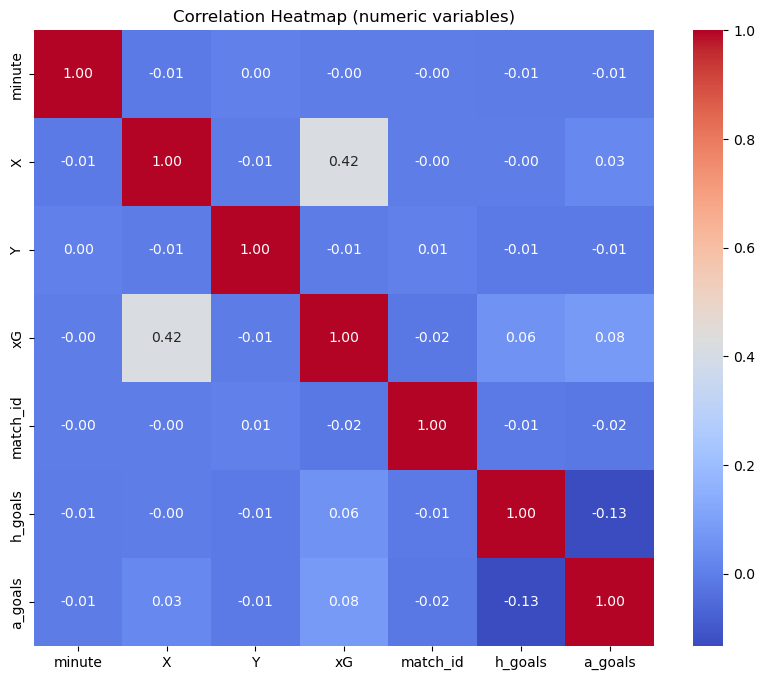

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 숫자형 컬럼만 선택
numeric_cols = shots_df.select_dtypes(include=['float64','int64'])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (numeric variables)")
plt.show()

- 상대 골대에 가까울수록(X 좌표↑) xG가 높아지는 경향이 있음
- Y도 중앙에 가까울 수록 상관관계가 높다고 생각했지만 상관관계가 낮음(비선형관계?)
- h_goals와 a_goals가 약한 상관관계가 존재하는 이유는 한 팀이 많이 넣으면 한 팀은 적게 넣을 가능성이 있음(약한 음의 상관관계)

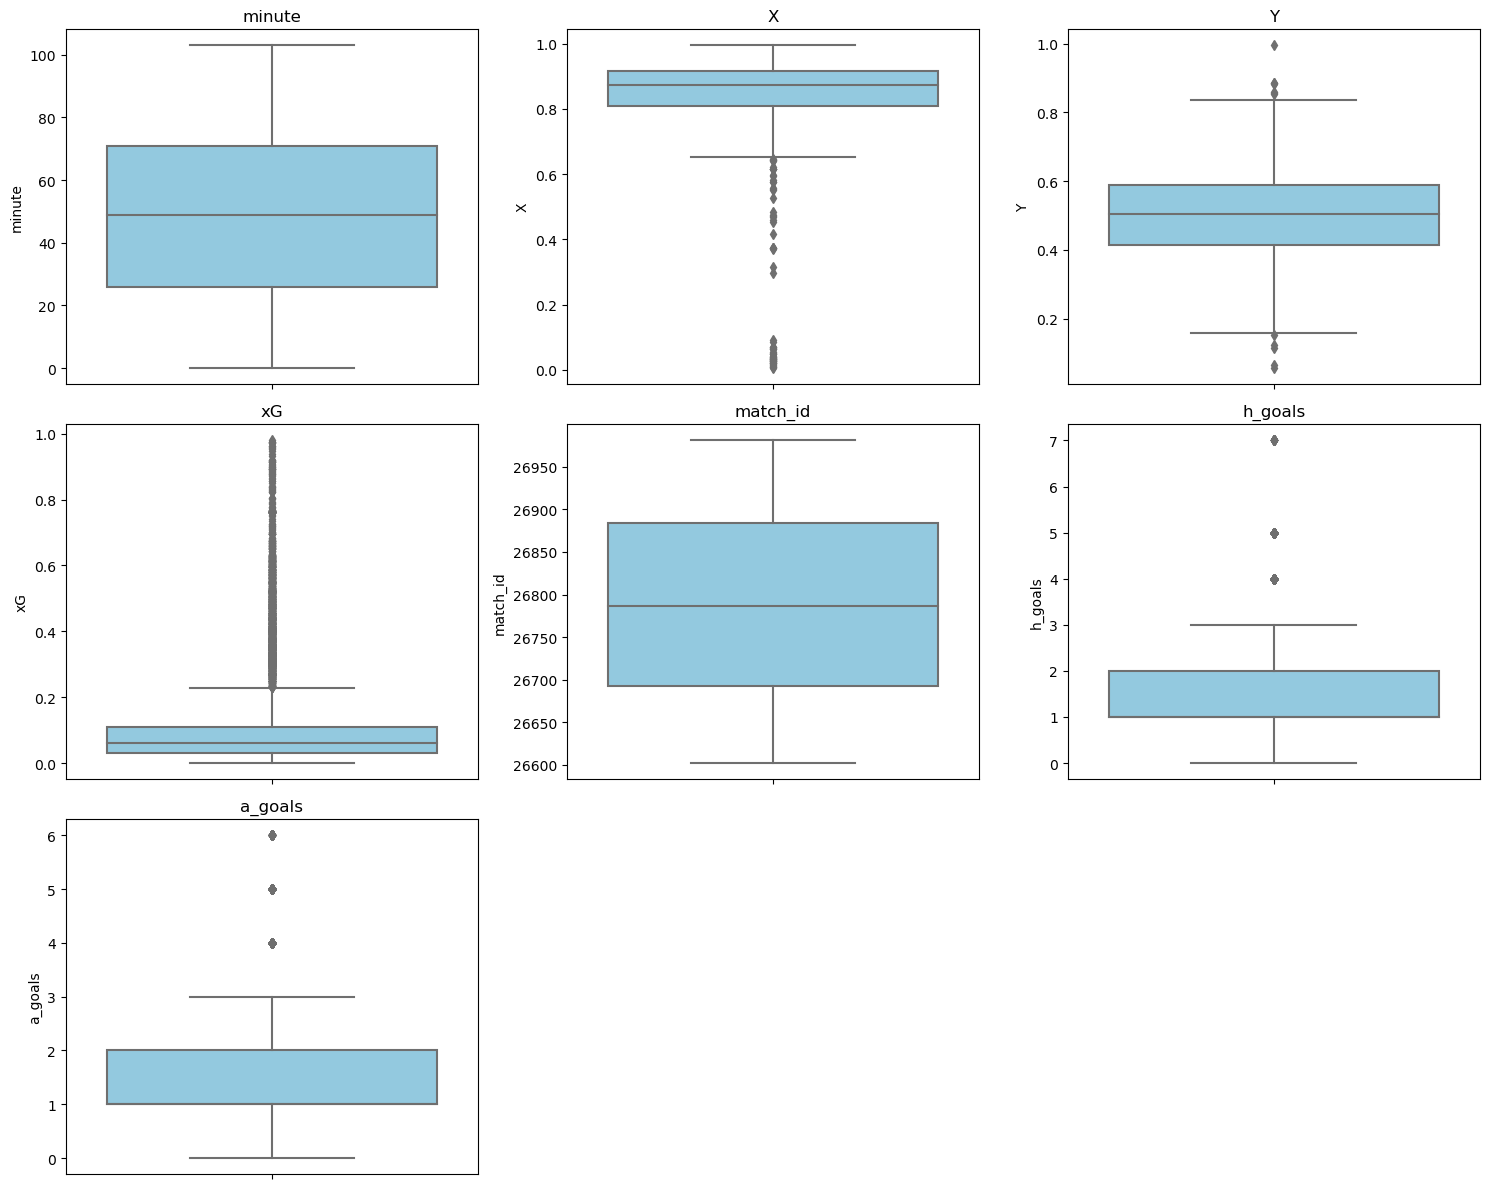

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 컬럼만 선택
numeric_cols = shots_df.select_dtypes(include=['float64','int64']).columns

# 서브플롯 크기 설정
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=shots_df[col], color='skyblue')
    plt.title(col)

plt.tight_layout()
plt.show()

모든 plot에서 이상치는 존재하지만, 실제 축구 경기에서 나올 수 있는 결과이기에 최대, 최소값을 확인 후 범위가 벗어나지 않는다면 처리x

In [28]:
print('minute: ', shots_df['minute'].min(), shots_df['minute'].max())
print('X: ', shots_df['X'].min(), shots_df['X'].max())
print('Y: ', shots_df['Y'].min(), shots_df['Y'].max())
print('xG: ', shots_df['xG'].min(), shots_df['xG'].max())
print('h_goals: ', shots_df['h_goals'].min(), shots_df['h_goals'].max())
print('a_goals: ', shots_df['a_goals'].min(), shots_df['a_goals'].max())

minute:  0 103
X:  0.0060000002384185 0.9940000152587892
Y:  0.0559999990463256 0.995
xG:  0.0 0.9793221354484558
h_goals:  0 7
a_goals:  0 6


리그의 경우 연장전이 없어 최대 90분이지만, 추가시간을 고려하면 103분이 가능하다고 판단
- 2024년 8월 17일 에버튼 vs 브라이튼 에서 전반 4분, 후반 9분의 추가시간을 받음

2024년 8월 25일 울버햄튼(H) : 첼시(A) (2:6)

2025년 1월 20일 입스위치(H) : 맨체스터시티(A) (0:6)

2025년 2월 1일 노팅엄(H) : 브라이튼(A) (7:0)

최대, 최소 확인 이상없음

(FotMob의 경기 기록 확인)